In [1]:
#%% Setting Up
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import networkx as nx
import rioxarray as rxr

import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

from shapely.geometry import Point
from shapely.geometry import Polygon

import glob
import os
import itertools
import tqdm
import gc
import time
import pickle

from joblib import Parallel, delayed

import rioxarray as rxr

import configparser
cfg = configparser.ConfigParser()
cfg.optionxform = str
cfg.read('/home/sarth/rootdir/datadir/assets/defaults.ini')
cfg = {s: dict(cfg.items(s)) for s in cfg.sections()}
PATHS = cfg['PATHS']

print("Setting up...")

Setting up...


In [2]:
#%% Region-Specific: CAMELS-US
DIRNAME = '03min_GloFAS_CAMELS-US'
SAVE_PATH = os.path.join(PATHS['devp_datasets'], DIRNAME)
resolution = 0.05
lon_360_180 = lambda x: (x + 180) % 360 - 180 # convert 0-360 to -180-180
lon_180_360 = lambda x: x % 360 # convert -180-180 to 0-360
region_bounds = {
    'minx': -130,
    'miny': 20,
    'maxx': -65,
    'maxy': 50
}
camels_attributes_graph = pd.read_csv(os.path.join(SAVE_PATH, 'graph_attributes.csv'), index_col=0)
camels_attributes_graph.index = camels_attributes_graph.index.map(lambda x: str(x).zfill(8))
camels_attributes_graph['huc_02'] = camels_attributes_graph['huc_02'].map(lambda x: str(x).zfill(2))
camels_graph = camels_attributes_graph.copy()
camels_graph = camels_graph[camels_graph['area_percent_difference'] < 10]
camels_graph = camels_graph[camels_graph['num_nodes'] > 1]
print(f"Number of CAMELS-US catmt's: {len(camels_graph)}")
del camels_attributes_graph

Number of CAMELS-US catmt's: 395


In [3]:
camels_graph.head()

,huc_02,gauge_lon,gauge_lat,area_geospa_fabric,snapped_lon,snapped_lat,snapped_uparea,snapped_iou,area_percent_difference,num_nodes,num_edges
gauge_id,,,,,,,,,,,
06452000,10,-99.55649,43.74833,25817.78,-99.525,43.775,26081.820,0.942874,1.022710,1158.0,1157.0
13340000,17,-116.25750,46.47833,14270.76,-116.275,46.475,14113.031,0.940266,1.105257,657.0,656.0
06447000,10,-101.52487,43.75250,12869.46,-101.575,43.725,12933.430,0.929852,0.497066,573.0,572.0
06360500,10,-100.84292,45.25582,12601.47,-100.875,45.275,12741.733,0.926271,1.113074,584.0,583.0
06354000,10,-100.93444,46.37611,10626.74,-100.925,46.375,10708.444,0.919406,0.768854,500.0,499.0


In [4]:
#%% GloFAS Grid
os.makedirs(os.path.join(SAVE_PATH, "graph_features"), exist_ok = True)

ldd = xr.open_dataset(os.path.join(PATHS['gis_ldd'], 'GloFAS_03min', 'ldd.nc'))
ldd = ldd['ldd']
ldd = ldd.sel(
    lat = slice(region_bounds['maxy'], region_bounds['miny']), 
    lon = slice(region_bounds['minx'], region_bounds['maxx'])
)

lons = ldd['lon'].values
lats = ldd['lat'].values

ds_grid = xr.Dataset({
    'lat': (['lat'], lats),
    'lon': (['lon'], lons),
})

# Round the lat lon values to 3 decimal places in ds_grid
ds_grid['lat'] = ds_grid['lat'].round(3)
ds_grid['lon'] = ds_grid['lon'].round(3)

In [ ]:
# incorrect_files = sorted(glob.glob(os.path.join(SAVE_PATH, "graph_features", "**", "precipitation.csv"), recursive=True))
# print(f"Number of incorrect files: {len(incorrect_files)}")
# for incorrect_file in tqdm.tqdm(incorrect_files):
#     os.remove(incorrect_file)
# del incorrect_files, incorrect_file

Number of incorrect files: 1


100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


# GPM

In [ ]:
def first_run(gpm_product, year):
    regridder_weights = os.path.join(PATHS['assets'], 'regridder', 'regridder_gpm_to_glofas_03min_US.nc')

    tif_files = sorted(glob.glob(f"{PATHS['GPM']}/{gpm_product}/{year}/*.tif")) # YYYY-MM-DD format
    tif_files = [f for f in tif_files if not ('-02-29' in f)] # Exclude leap days
    print(f"Number of tif files: {len(tif_files)}")

    tif_file = tif_files[0]
    ds = rxr.open_rasterio(tif_file, masked=True).squeeze()
    ds = ds.sel(
        x = slice(region_bounds['minx'], region_bounds['maxx']), 
        y = slice(region_bounds['miny'], region_bounds['maxy'])
    )
    ds = ds.drop_vars(['band', 'spatial_ref'], errors='ignore')
    ds = ds.rename({'x': 'lon', 'y': 'lat'})

    # Print the shape of the dataset
    print(f"Shape of the dataset: {ds.shape}")

    if not os.path.exists(regridder_weights):
        regridder = xe.Regridder(
            ds, 
            ds_grid, 
            'bilinear', 
            reuse_weights=False, 
            # filename = regridder_weights
        )
        regridder.to_netcdf(regridder_weights)
    else:
        regridder = xe.Regridder(
            ds, 
            ds_grid, 
            'bilinear', 
            reuse_weights=True, 
            filename = regridder_weights
        )

    ds_regrided = regridder(ds)
    print(f"Shape of the regridded dataset: {ds_regrided.shape}")
    ds.close()
    ds_regrided.close()

    del regridder, ds, ds_regrided
    gc.collect()

    return None

In [ ]:
def yearly_run(year, gpm_product, verbose=False):
    regridder_weights = os.path.join(PATHS['assets'], 'regridder', 'regridder_gpm_to_glofas_03min_US.nc')

    tif_files = sorted(glob.glob(f"{PATHS['GPM']}/{gpm_product}/{year}/*.tif")) # YYYY-MM-DD format
    tif_files = [f for f in tif_files if not ('-02-29' in f)] # Exclude leap days
    if verbose: print(f"Number of tif files: {len(tif_files)}")

    def load_tif(tif_file):
        da = rxr.open_rasterio(tif_file, masked=True).squeeze()
        da = da.sel(
            x = slice(region_bounds['minx'], region_bounds['maxx']), 
            y = slice(region_bounds['miny'], region_bounds['maxy'])
        )
        da = da.drop_vars(['band', 'spatial_ref'], errors='ignore')
        da = da.rename({'x': 'lon', 'y': 'lat'})
        return da
    
    ds_list = Parallel(n_jobs=-1)(
        delayed(load_tif)(tif_file) for tif_file in tif_files
    )
    ds = xr.concat(ds_list, dim='time')
    del ds_list
    gc.collect()

    if verbose: print(f"Shape of the dataset: {ds.shape}")

    if not os.path.exists(regridder_weights):
        regridder = xe.Regridder(
            ds, 
            ds_grid, 
            'bilinear', 
            reuse_weights=False, 
            # filename = regridder_weights
        )
        regridder.to_netcdf(regridder_weights)
    else:
        regridder = xe.Regridder(
            ds, 
            ds_grid, 
            'bilinear', 
            reuse_weights=True, 
            filename = regridder_weights
        )

    ds_regrided = regridder(ds)
    if verbose: print(f"Shape of the regridded dataset: {ds_regrided.shape}")
    ds.close()
    del regridder, ds

    dates = [os.path.basename(f).split('.')[0] for f in tif_files]
    dates = pd.to_datetime(dates, format='%Y-%m-%d')

    ds_regrided['time'] = ('time', dates)

    # Set DataArray ds_regrided to float32
    ds_regrided = ds_regrided.astype('float32')

    ds_regrided.load()

    def process(idx, row):
        huc, gauge_id = row['huc_02'], row.name
        nodes_coords = pd.read_csv(os.path.join(SAVE_PATH, 'graph_files', huc, gauge_id, 'nodes_coords.csv'), index_col = 0)
        data = pd.DataFrame(index = dates, columns = nodes_coords.index.astype(str))
        for node_idx, node_row in nodes_coords.iterrows():
            lat, lon = node_row['lat'], node_row['lon']
            ds_window_loc = ds_regrided.sel(lat = lat, lon = lon, method = 'nearest')
            data.loc[:, str(node_idx)] = ds_window_loc.values
        assert not data.isna().any().any(), f"NaN values found in data for {huc} {gauge_id}"
        data = data.astype('float32')
        os.makedirs(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'dynamic', 'GPM', gpm_product), exist_ok=True)
        data.to_csv(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'dynamic', 'GPM', gpm_product, f"{year}.csv"))

    with Parallel(n_jobs = 8, verbose = 0) as parallel:
        _ = parallel(delayed(process)(idx, row) for idx, row in tqdm.tqdm(camels_graph.iterrows(), total=len(camels_graph), desc=f"{gpm_product} {year}"))
        # _ = parallel(delayed(process)(idx, row) for idx, row in camels_graph.iterrows())

    ds_regrided.close()
    del ds_regrided
    gc.collect()

    return None

In [32]:
start_year = 2016
end_year = 2019
gpm_product = 'Early_Run'

In [ ]:
first_run(gpm_product, start_year)

Number of tif files: 365
Shape of the dataset: (300, 650)
Shape of the regridded dataset: (600, 1300)


In [ ]:
for year in range(start_year, end_year + 1):
    yearly_run(year, gpm_product, verbose=False)

Final_Run 2019: 100%|██████████| 395/395 [00:05<00:00, 71.95it/s] 


In [37]:
for year in range(1998+1, 2022 + 1):
    if not year in range(start_year, end_year + 1):
        yearly_run(year, gpm_product, verbose=False)

Early_Run 2022: 100%|██████████| 395/395 [00:05<00:00, 68.82it/s] 


# ECMWF_HRES

In [ ]:
# from dask.distributed import Client
# client = Client(n_workers=32, threads_per_worker=1)
# client.close()

In [14]:
hres = xr.open_zarr(os.path.join(PATHS['WeatherBench2'], 'ECMWF_HRES_2016_2022.zarr'), consolidated=True, chunks="auto")

hres['prediction_timedelta'] = hres['prediction_timedelta'].astype('float32')  # Ensure the dtype is float32
hres['prediction_timedelta'] = hres['prediction_timedelta'] / (1e9 * 3600)  # Convert to hours
hres['prediction_timedelta'] = hres['prediction_timedelta'].astype('int32')  # Ensure the dtype is int32

hres['longitude'] = lon_360_180(hres['longitude'])
hres = hres.sortby(['longitude', 'latitude', 'prediction_timedelta'])
hres = hres.rename({'longitude': 'lon', 'latitude': 'lat'})
hres = hres.sel(
    lat = slice(region_bounds['miny'], region_bounds['maxy']), 
    lon = slice(region_bounds['minx'], region_bounds['maxx'])
)

hres = hres.sel(time=hres['time'][~((hres['time'].dt.month == 2) & (hres['time'].dt.day == 29))])
# hres = hres.sel(time = ~(hres['time'].dt.month.isin([2]) & hres['time'].dt.day.isin([29])))

hres

<xarray.Dataset> Size: 18GB
Dimensions:                   (time: 2555, prediction_timedelta: 11, lat: 121,
                               lon: 261)
Coordinates:
  * lat                       (lat) float32 484B 20.0 20.25 20.5 ... 49.75 50.0
  * lon                       (lon) float32 1kB -130.0 -129.8 ... -65.25 -65.0
  * prediction_timedelta      (prediction_timedelta) int32 44B 0 24 ... 216 240
  * time                      (time) datetime64[ns] 20kB 2016-01-01 ... 2022-...
Data variables:
    10m_u_component_of_wind   (time, prediction_timedelta, lat, lon) float32 4GB dask.array<chunksize=(1, 1, 121, 261), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, lat, lon) float32 4GB dask.array<chunksize=(1, 1, 121, 261), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, lat, lon) float32 4GB dask.array<chunksize=(1, 1, 121, 261), meta=np.ndarray>
    surface_pressure          (time, prediction_timedelta, lat, lon) float32 4GB dask.array<chunksize=(1, 1, 121, 261), meta=np.ndarray>
    total_precipitation_24hr  (time, prediction_timedelta, lat, lon) float32 4GB dask.array<chunksize=(1, 1, 121, 261), meta=np.ndarray>

In [15]:
lead_times = hres['prediction_timedelta'].values[1:]
print(f"Lead times: {lead_times}")

Lead times: [ 24  48  72  96 120 144 168 192 216 240]


In [16]:
var_names = list(hres.data_vars)
print(f"Variable names: {var_names}")

Variable names: ['10m_u_component_of_wind', '10m_v_component_of_wind', '2m_temperature', 'surface_pressure', 'total_precipitation_24hr']


In [ ]:
for var_name in var_names:
    print(f"Processing {var_name}")
    for lead_time in lead_times:
        subset = hres[var_name].sel(prediction_timedelta=lead_time)
        # subset = subset.compute()
        # subset.load()

        regridder_weights = os.path.join(PATHS['assets'], 'regridder', 'regridder_ecmwf_hres_to_glofas_03min_US.nc')

        if not os.path.exists(regridder_weights):
            regridder = xe.Regridder(
                subset, 
                ds_grid, 
                'bilinear', 
                reuse_weights=False, 
                # filename = regridder_weights
            )
            regridder.to_netcdf(regridder_weights)
        else:
            regridder = xe.Regridder(
                subset, 
                ds_grid, 
                'bilinear', 
                reuse_weights=True, 
                filename = regridder_weights
            )

        ds_regrided = regridder(subset)
        subset.close()
        del regridder, subset
        ds_regrided.load()

        def process(idx, row):
            huc, gauge_id = row['huc_02'], row.name
            nodes_coords = pd.read_csv(os.path.join(SAVE_PATH, 'graph_files', huc, gauge_id, 'nodes_coords.csv'), index_col = 0)
            data = pd.DataFrame(index=ds_regrided['time'].values, columns=nodes_coords.index.astype(str))
            for node_idx, node_row in nodes_coords.iterrows():
                lat, lon = node_row['lat'], node_row['lon']
                ds_window_loc = ds_regrided.sel(lat=lat, lon=lon, method='nearest')
                data.loc[:, str(node_idx)] = ds_window_loc.values
            assert not data.isna().any().any(), f"NaN values found in data for {huc} {gauge_id}"
            data = data.astype('float32')
            os.makedirs(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'dynamic', 'ECMWF_HRES', var_name), exist_ok=True)
            data.to_csv(os.path.join(SAVE_PATH, "graph_features", huc, gauge_id, 'dynamic', 'ECMWF_HRES', var_name, f"{lead_time}hrs.csv"))

        with Parallel(n_jobs = 8, verbose = 0) as parallel:
            _ = parallel(delayed(process)(idx, row) for idx, row in tqdm.tqdm(camels_graph.iterrows(), total=len(camels_graph), desc=f"{lead_time}hrs"))
            # _ = parallel(delayed(process)(idx, row) for idx, row in camels_graph.iterrows())

        ds_regrided.close()
        del ds_regrided
        gc.collect()

In [ ]:
# Size of hres in GB
# print(f"Size of hres: {hres['total_precipitation_24hr'].isel(prediction_timedelta = 1).nbytes / 1e9:.2f} GB")

Size of hres: 0.32 GB


# MERIT Hydro

In [5]:
import richdem as rd
def calculate_terrain_attributes(dem):
    slope_percentage = rd.TerrainAttribute(dem, attrib='slope_percentage')
    slope_riserun = rd.TerrainAttribute(dem, attrib='slope_riserun')
    slope_degrees = rd.TerrainAttribute(dem, attrib='slope_degrees')
    slope_radians = rd.TerrainAttribute(dem, attrib='slope_radians')
    aspect = rd.TerrainAttribute(dem, attrib='aspect')
    curvature = rd.TerrainAttribute(dem, attrib='curvature')
    planform_curvature = rd.TerrainAttribute(dem, attrib='planform_curvature')
    profile_curvature = rd.TerrainAttribute(dem, attrib='profile_curvature')
    results = {
        'slope_percentage': slope_percentage,
        'slope_riserun': slope_riserun,
        'slope_degrees': slope_degrees,
        'slope_radians': slope_radians,
        'aspect': aspect,
        'curvature': curvature,
        'planform_curvature': planform_curvature,
        'profile_curvature': profile_curvature
    }
    return results

In [6]:
row = camels_graph.iloc[0]
huc, gauge_id = row['huc_02'], row.name
nodes_coords = pd.read_csv(os.path.join(SAVE_PATH, 'graph_files', huc, gauge_id, 'nodes_coords.csv'), index_col=0)
minx, miny = nodes_coords['lon'].min(), nodes_coords['lat'].min()
maxx, maxy = nodes_coords['lon'].max(), nodes_coords['lat'].max()
buffer = 0.5
minx, miny, maxx, maxy = minx - buffer, miny - buffer, maxx + buffer, maxy + buffer

In [7]:
def coords_to_polygon(lon, lat, resolution):
    half_res = resolution / 2
    return Polygon([
        (round(lon - half_res,3), round(lat - half_res,3)),
        (round(lon - half_res,3), round(lat + half_res,3)),
        (round(lon + half_res,3), round(lat + half_res,3)),
        (round(lon + half_res,3), round(lat - half_res,3))
    ])
def tile_filename_to_coords(filename):
    # format: n/s{dd}e/w{ddd}_elv.tif
    # n/e: positive, s/w: negative
    n_s, lat, e_w, lon = filename[0], int(filename[1:3]), filename[3], int(filename[4:7])
    lat = lat if n_s == 'n' else -lat
    lon = lon if e_w == 'e' else -lon
    return (lon, lat)

In [8]:
tiles_paths = sorted(glob.glob(os.path.join(PATHS['MERIT-Hydro'], 'elv', '**', '*.tif'), recursive=True))
# tiles_paths = [tile for tile in tiles_paths if os.path.basename(os.path.dirname(tile)).split('_')[-1] in valid_tiles]
tiles_filenames = [os.path.basename(tile) for tile in tiles_paths]
tiles_names = [tile.split('_')[0] for tile in tiles_filenames]
tiles_lower_left_corner = [tile_filename_to_coords(tile) for tile in tiles_filenames]
tiles_polygons = [Polygon([(lon, lat), (lon + 5, lat), (lon + 5, lat + 5), (lon, lat + 5)]) for lon, lat in tiles_lower_left_corner]

print(f"Number of tiles: {len(tiles_paths)}")

Number of tiles: 1150


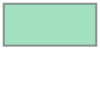

In [9]:
catmt_polygon = Polygon([
    (minx, miny),
    (minx, maxy),
    (maxx, maxy),
    (maxx, miny),
    (minx, miny)
])
catmt_polygon

In [10]:
intersected_tiles = []
for tile_polygon, tile_path in zip(tiles_polygons, tiles_paths):
    if tile_polygon.intersects(catmt_polygon):
        intersected_tiles.append(tile_path)
print(f"Number of intersected tiles: {len(intersected_tiles)}")

Number of intersected tiles: 2


In [11]:
ds = rxr.open_rasterio(intersected_tiles[0])
for tile in intersected_tiles[1:]:
    ds = ds.combine_first(rxr.open_rasterio(tile))
ds = ds.sel(band=1)
ds = ds.sortby('x', ascending=True)
ds = ds.sortby('y', ascending=True)
ds

<xarray.DataArray (y: 6000, x: 12000)> Size: 288MB
array([[1593.2001 , 1590.3    , 1588.5    , ...,  257.2    ,  257.5    ,
         258.1    ],
       [1595.3    , 1592.5    , 1591.3    , ...,  257.     ,  257.5    ,
         258.7    ],
       [1594.6    , 1593.5    , 1592.2001 , ...,  256.80002,  258.2    ,
         257.6    ],
       ...,
       [1207.1    , 1206.3    , 1206.5    , ...,  341.6    ,  340.2    ,
         340.5    ],
       [1211.2001 , 1211.1    , 1209.2001 , ...,  340.7    ,  340.6    ,
         340.6    ],
       [1214.     , 1212.9    , 1212.8    , ...,  340.1    ,  340.6    ,
         340.7    ]], shape=(6000, 12000), dtype=float32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 96kB -105.0 -105.0 -105.0 ... -95.0 -95.0 -95.0
  * y            (y) float64 48kB 40.0 40.0 40.0 40.0 ... 45.0 45.0 45.0 45.0
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0

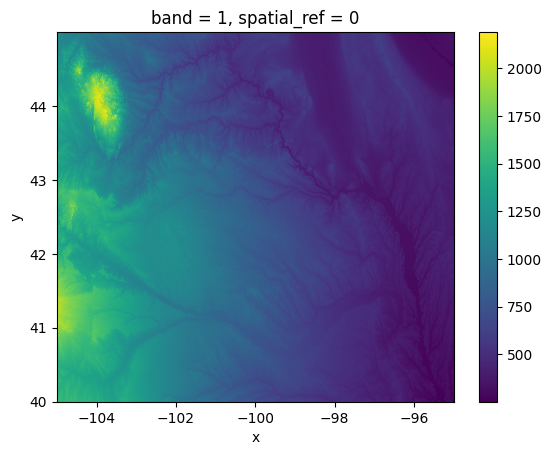

In [18]:
ds.plot()

In [14]:
# Save ds as a GeoTIFF
ds.rio.to_raster(os.path.join(SAVE_PATH, 'graph_files', huc, gauge_id, 'dem.tif'), driver='GTiff', dtype='float32')

In [30]:
# Use ds in richdem
dem = rd.LoadGDAL(os.path.join(SAVE_PATH, 'graph_files', huc, gauge_id, 'dem.tif'))
# Optionally fill depressions:
dem_filled = rd.FillDepressions(dem)
warnings.filterwarnings('ignore')
terrain_attributes = calculate_terrain_attributes(dem)


A Priority-Flood (Zhou2016 version)
C Zhou, G., Sun, Z., Fu, S., 2016. An efficient variant of the Priority-Flood algorithm for filling depressions in raster digital elevation models. Computers & Geosciences 90, Part A, 87 – 96. doi:http://dx.doi.org/10.1016/j.cageo.2016.02.021

t Zhou2016 wall-time = 18.2654 s

A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

W Cell X and Y dimensions are not equal!
t Wall-time = 1.35346                         ] (39% - 2.1s - 1 threads)         ] (10% - 1.2s - 1 threads)ads)=======                     ] (59% - 0.6s - 1 threads)

A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

W Cell X and Y dimensions are not equal!
t Wall-time = 1.31984                         ] (39% - 2.0s - 1 threads)                                              ] (7% -

t Wall-time = 3.49347                         ] (39% - 5.4s - 1 threads))

A Slope calculation (radians)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

W Cell X and Y dimensions are not equal!
t Wall-time = 3.42081                         ] (39% - 5.3s - 1 threads))

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

W Cell X and Y dimensions are not equal!
t Wall-time = 5.05904                         ] (39% - 7.8s - 1 threads))

A Curvature attribute calculation
C Zevenbergen, L.W., Thorne, C.R., 1987. Quantitative analysis of land surface topography. Earth surface processes and landforms 12, 47–56.

W Cell X and Y dimensions are not equal!
t Wall-time = 0.806249                        ] (39% - 1.2s - 1 threads)

A Planform curvature attribute calculation
C Zevenbergen, L.W., Thorne, C.R., 1987. Quantitati

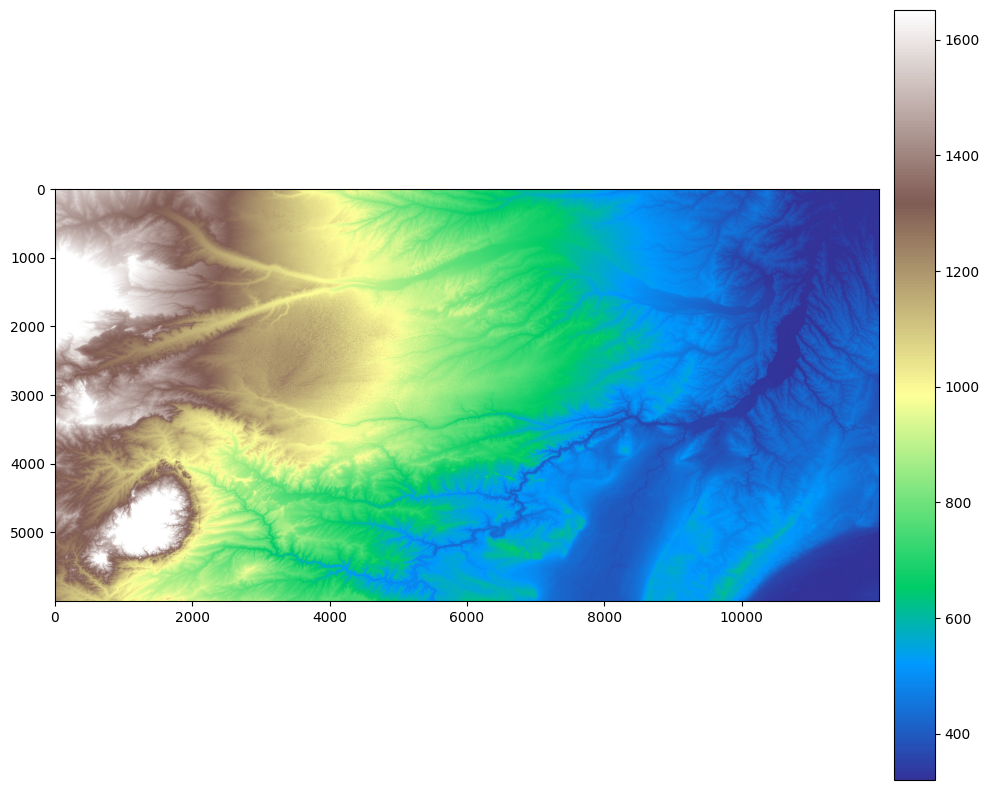

{'vmin': np.float64(320.0), 'vmax': np.float64(1651.5999755859375)}

In [31]:
rd.rdShow(dem, figsize=(10, 8), cmap='terrain')
# plt.figure(figsize=(10, 8))
# plt.imshow(dem, cmap='terrain')
# plt.colorbar()
# plt.title("RichDEM Raster")
# plt.show()

In [19]:
list(terrain_attributes.keys())

['slope_percentage',
 'slope_riserun',
 'slope_degrees',
 'slope_radians',
 'aspect',
 'curvature',
 'planform_curvature',
 'profile_curvature']

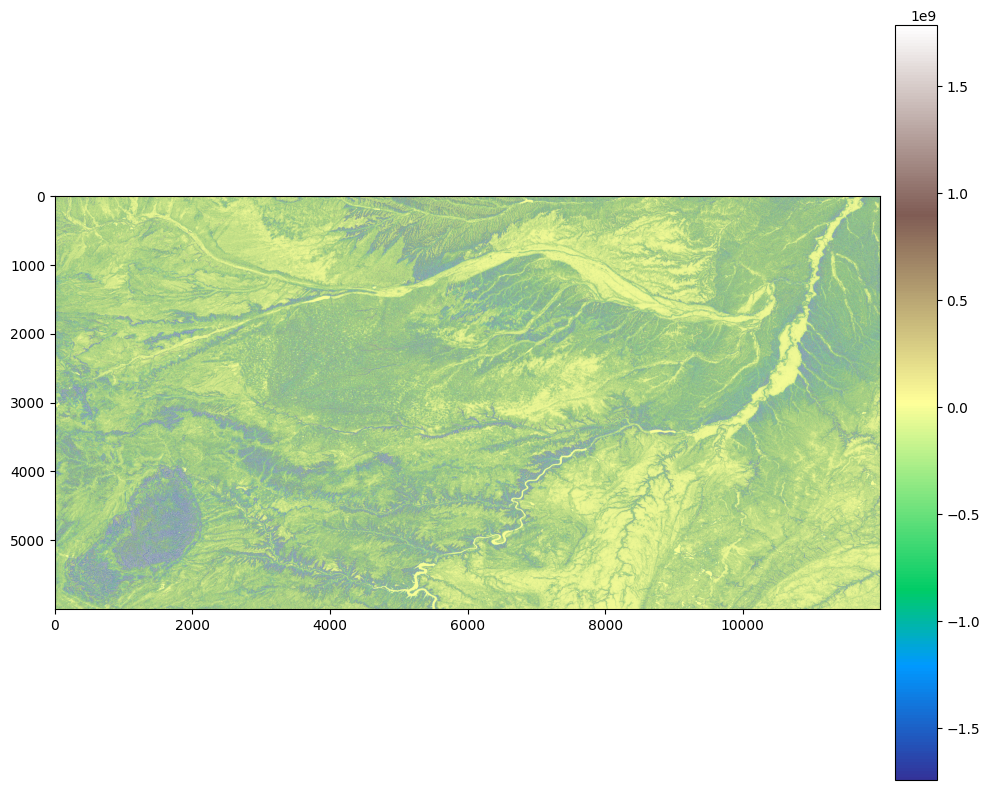

{'vmin': np.float64(-1742396544.0), 'vmax': np.float64(1785594752.0)}

In [32]:
rd.rdShow(terrain_attributes['curvature'], figsize=(10, 8), cmap='terrain')

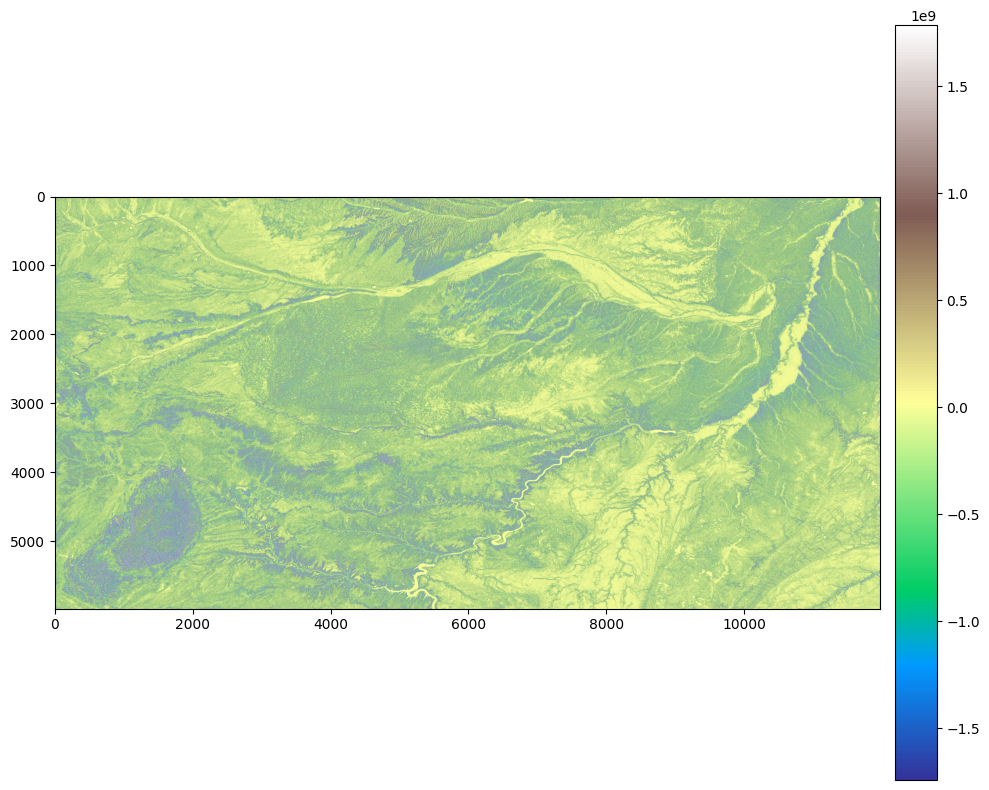

{'vmin': np.float64(-1742396544.0), 'vmax': np.float64(1785594752.0)}

In [24]:
# terrain_attributes['curvature'] Exclude 10 from each direction
temp = terrain_attributes['curvature'].copy()
temp = temp[10:-10, 10:-10]
rd.rdShow(temp, figsize=(10, 8), cmap='terrain')

In [34]:
# terrain_attributes['curvature']: What fraction of the points have abs curvature values greater than 1e3
print(f"Fraction of points with abs curvature > 1e3: {np.sum(np.abs(terrain_attributes['curvature']) > 1e6) / terrain_attributes['curvature'].size:.4f}")

Fraction of points with abs curvature > 1e3: 0.9809


# Development

Below is a summary of the typical ranges you may encounter for each attribute. Note that the “mathematical” ranges reflect theory or how the metric is defined, while the “practical” ranges indicate what you often see in natural terrains, which can be further limited by the DEM resolution and processing method.

- **slope_percentage**  
  - *Mathematical:* 0% to ∞ (since it’s 100 × rise/run).  
  - *Practical:* Most natural slopes are below 100–200%, though very steep features (e.g., cliffs) can exceed 200%.

- **slope_riserun**  
  - *Mathematical:* 0 to ∞ (a ratio with 1 corresponding to a 45° slope).  
  - *Practical:* Gentle terrain usually has values much less than 1, while very steep slopes may have values around or above 1.

- **slope_degrees**  
  - *Mathematical:* 0° to 90° (with 90° being a vertical slope).  
  - *Practical:* Most slopes in a DEM fall below about 60°; near-vertical slopes are uncommon.

- **slope_radians**  
  - *Mathematical:* 0 to π/2 radians (0 to approx. 1.57 radians).  
  - *Practical:* Typically, slopes are under about 1 radian in most landscapes.

- **aspect**  
  - *Mathematical:* 0° to 360° (or 0 to 2π radians), often measured clockwise from north.  
  - *Practical:* All directions are possible. However, in flat areas the aspect may be undefined or set to a default value.

- **curvature**  
  - *Mathematical:* In theory, any real number because it’s the second derivative (units of 1/length).  
  - *Practical:* Values tend to be small fractions. A near-zero curvature indicates flatness; positive values suggest convex (diverging) terrain, and negative values indicate concave (converging) terrain. Often, you’ll see magnitudes less than 1/m, typically on the order of 0.1–0.5 1/m.

- **planform_curvature**  
  - *Mathematical:* Can range over all real numbers.  
  - *Practical:* Because it reflects the horizontal component (flow divergence/convergence), values are usually moderate (often in the range −0.2 to 0.2 1/m) but depend greatly on the DEM resolution and smoothing.

- **profile_curvature**  
  - *Mathematical:* Also unbounded in theory (1/length).  
  - *Practical:* Since this indicates the convexity/concavity along the slope direction, values are small and might typically range between about −0.3 to 0.3 1/m.

These ranges can vary depending on the DEM’s resolution, the smoothing applied during processing, and the characteristics of the study area. Adjust these expectations as needed for your particular dataset.